In [1]:
import warnings
warnings.filterwarnings('ignore')
import FateAxis.tool.main_function as fa
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import FateAxis.tool.extractor as ext
import cospar as cs
import wot
import scipy.stats as stats
from scipy.stats import rankdata
import FateAxis.tool.preprocessor as pp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed.h5ad')

In [3]:
adata.obs['day'] = 2
adata.obs.loc[adata.obs['celltype'] == 'early', 'day'] = 1

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True,flavor='seurat_v3')

In [5]:
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 
#tmaps = ot_model.compute_transport_map(2,1,tmap_out='/data/jiangjunyao/easyGRN/processed_data/mouse_hematopoiesis/ot/')
ot_model.compute_all_transport_maps(tmap_out='/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep/ot/')

2025-06-05 22:51:03,778 - INFO - Computing transport map from 1 to 2


In [6]:
celltype_dict = adata.obs.groupby('celltype').apply(lambda x: x.index.tolist()).to_dict()
print(celltype_dict.keys())
tmap_model = wot.tmap.TransportMapModel.from_directory('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep/ot/')

dict_keys(['dead-end', 'early', 'reprogramming'])


In [7]:
target_destinations = tmap_model.population_from_cell_sets(celltype_dict, at_time=2)
fate_ds = tmap_model.fates(target_destinations)

In [8]:
max_indices = np.argmax(fate_ds.X, axis=1)

max_var_names = [fate_ds.var_names[idx] for idx in max_indices]

result = list(max_var_names)
fate_ds.obs['pred'] = result

In [9]:
adata.obs.celltype.value_counts()

dead-end         3814
reprogramming    3184
early            1139
Name: celltype, dtype: int64

In [10]:
common_index = adata.obs.index.intersection(fate_ds.obs.index)
fate_data = fate_ds.obs.loc[common_index, 'pred']
adata.obs.loc[common_index, 'pred'] = fate_data

In [11]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

adata_filter = adata[adata.obs.celltype=='early']
y_pred = adata_filter.obs['pred']
y_true = adata_filter.obs['lineage']

accuracy = accuracy_score(y_true, y_pred)

recall = recall_score(y_true, y_pred, average='macro')


f1 = f1_score(y_true, y_pred, average='macro')


print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.646180860403863
Recall: 0.70879386513295
F1 Score: 0.6247828684982143


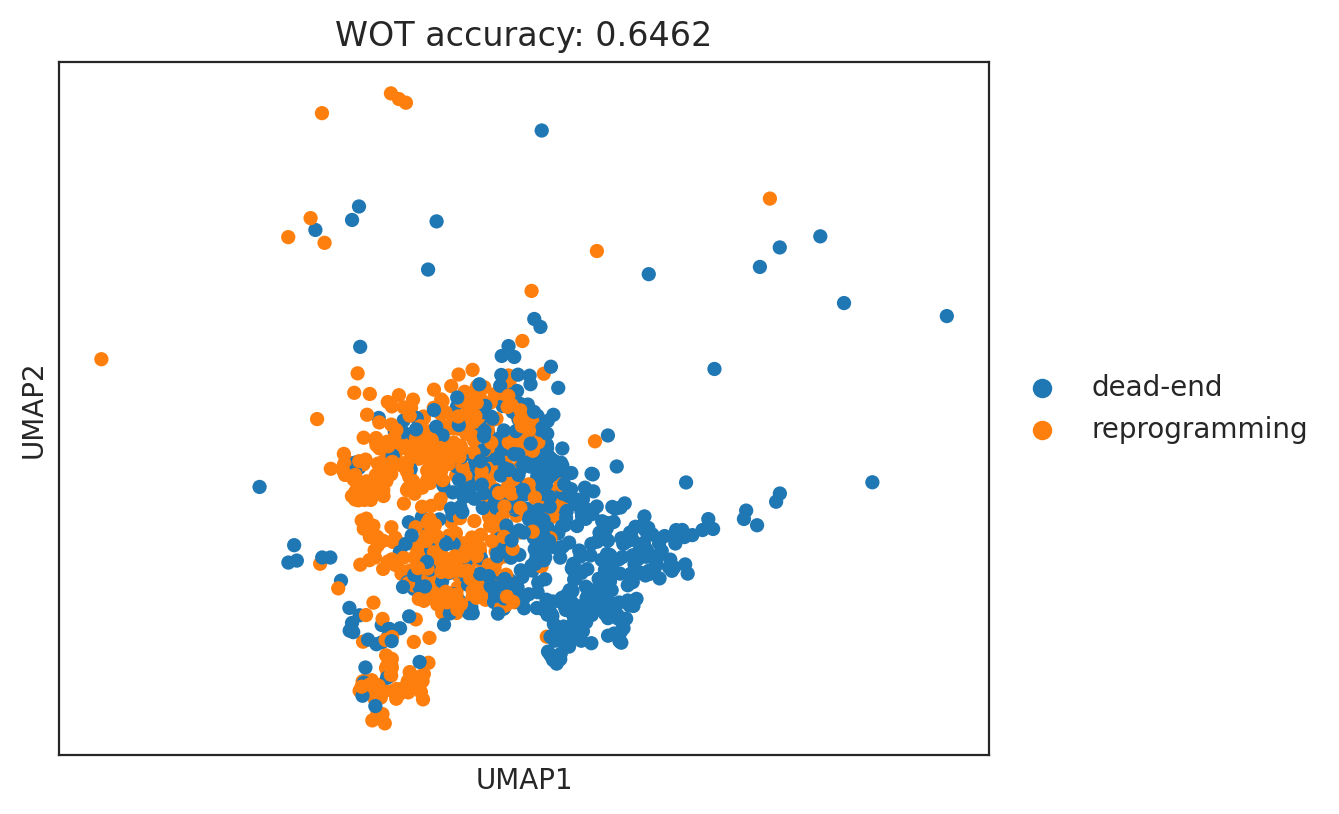

In [13]:
sc.pl.umap(adata_filter,color=['pred'],title='WOT accuracy: 0.6462')

In [15]:
adata.write('/data/jiangjunyao/AEGAS_analysis/pred_result/wot_celltag_multi_rna_hvg.h5ad')

... storing 'pred' as categorical


In [16]:
adata.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/wot_celltag_multi_rna_obs.csv')